<a href="https://colab.research.google.com/github/pinilDissanayaka/Multi-Vector-Retriever-for-RAG-on-Tables-Texts/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,372 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
pip install langchain-google-vertexai --upgrade

In [ ]:
pip install --upgrade nltk

In [119]:
pip install -r requirements.txt

In [182]:
import os
import uuid
import requests
import base64
from PIL import Image
from unstructured.partition.pdf import partition_pdf
from langchain_core.documents import Document
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_groq.chat_models import ChatGroq
from langchain_google_vertexai import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.schema.document import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.messages import HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from google.colab import userdata

In [121]:
os.environ['GROQ_API_KEY']=userdata.get('GROQ_API_KEY')
os.environ["GOOGLE_API_KEY"]=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_PROJECT_ID"]=userdata.get('GOOGLE_PROJECT_ID')
os.environ["PINECONE_API_KEY"]=userdata.get('PINECORN_API_KEY')

In [77]:
file_path="/content/llama3.pdf"

with open(file_path, "wb") as file:
  response = requests.get("https://arxiv.org/pdf/2302.13971")
  file.write(response.content)

In [7]:
output_path = "./images"

In [84]:
raw_pdf_elements = partition_pdf(
    filename=file_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

In [85]:
for element in raw_pdf_elements:
  print(type(element))

<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstruc

In [86]:
llm=ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)

In [183]:
summary_prompt_template='''Summarize the key insights from the table.
Focus on highlighting major trends, patterns, or significant values.
Include comparisons where applicable and note any outliers or anomalies.
Provide a clear and concise summary that captures the essence of the {table_data}.'''


summary_prompt=ChatPromptTemplate.from_template(summary_prompt_template)

print(f"Summary prompt {summary_prompt}")

summary_chain=summary_prompt | llm | StrOutputParser()

Summary prompt input_variables=['table_data'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['table_data'], template='Summarize the key insights from the table.\nFocus on highlighting major trends, patterns, or significant values.\nInclude comparisons where applicable and note any outliers or anomalies.\nProvide a clear and concise summary that captures the essence of the {table_data}.'))]


In [184]:
table_count=0
table_elements=list()
table_summary=list()

text_count=0
text=list()

for element in raw_pdf_elements:
  if str(type(element))=="<class 'unstructured.documents.elements.Table'>":
    table_count+=1
    table_elements.append(element.text)
    table_summary.append(Document(
        page_content=summary_chain.invoke({"table_data" :element.text }),
        metadata={
            "id":str(uuid.uuid4()),
            "type":"table"
        }
        )
    )
  else:
    text_count+=1
    text.append(Document(
        page_content=element.text,
        metadata={
            "id":str(uuid.uuid4()),
            "type":"text"
        }
        )
    )

In [185]:
print(f"Text element count = {text_count}")
print(f"Table element count = {table_count}")

Text element count = 42
Table element count = 16


In [186]:
gemini= ChatVertexAI(
    model="gemini-1.5-pro",
    temperature=0.2,
    max_tokens=None,
    max_retries=6,
    stop=None,
)

In [205]:
def summarizePrompt(image_data):
  image_message = {
      "type": "image_url",
      "image_url": {
          "url": f"data:image/jpeg;base64,{base64.b64encode(image_data).decode('utf-8')}"
      },
  }
  text_message = {
      "type": "text",
      "text": "What is shown in this image?",
  }

  message = HumanMessage(content=[text_message, image_message])
  return [message]

In [206]:
image_summary_chain=RunnableLambda(summarizePrompt) | gemini | StrOutputParser()

In [208]:
image_count=0
image_elements=list()
image_summary=[]


for image in os.listdir(output_path):
  image_path=os.path.join(output_path, image)
  with open(image_path, "rb") as img:
    image_data=img.read()
    base64_encoded_data=base64.b64encode(image_data).decode('utf-8')
  img=Image.open(image_path)
  image_count+=1
  image_elements.append(base64_encoded_data)
  image_summary.append(
      Document(
          page_content=image_summary_chain.invoke(image_data),
          metadata={
              "id":str(uuid.uuid4()),
              "type":"image",
              "image_path":image_path
              }
          )
      )

/usr/local/lib/python3.10/dist-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [209]:
image_summary[0]

Document(metadata={'id': '4fea7da4-2569-400b-9dc1-6880a9203552', 'type': 'image', 'image_path': './images/figure-8-2.jpg'}, page_content="The image shows six line graphs, each representing the performance of different sizes of the LLaMA language model (7B, 13B, 33B, and 65B parameters) on six different question-answering benchmarks (TriviaQA, HellaSwag, NaturalQuestions, SIQA, WinoGrande, and PIQA). \n\nHere's a breakdown:\n\n* **X-axis:** Billion of tokens used in training the model. This indicates the amount of data the model has been trained on.\n* **Y-axis:** Accuracy of the model on the respective benchmark. Higher accuracy indicates better performance.\n* **Each line:** Represents the performance of a specific LLaMA model size as it is trained on more data.\n* **Dashed purple line:** Represents the performance of the Chinchilla language model, serving as a baseline for comparison.\n\n**Key Observations:**\n\n* **Generally, larger models perform better:**  Across all benchmarks, t

In [210]:
documents=[]
for i in text:
  documents.append(i)
for i in table_summary:
  documents.append(i)
for i in image_summary:
  documents.append(i)

In [211]:
dimension=768
embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [212]:
document_chunks=RecursiveCharacterTextSplitter(chunk_size=1200,
                                               chunk_overlap=600,
                                               length_function=len,
                                               is_separator_regex=False).split_documents(documents=documents)

In [217]:
pinecone=Pinecone()

print(f"List of all indexes in pinecone : {pinecone.list_indexes().names()}")

List of all indexes in pinecone : ['randika']


In [218]:
def createIndex(indexName:str, dimension:int):
  try:
    pinecone=Pinecone()
    if indexName not in pinecone.list_indexes().names():
      pinecone.create_index(
          name=indexName,
          dimension=dimension,
          metric="cosine",
          spec=ServerlessSpec(cloud='aws',
                            region='us-east-1')
      )
      print(f"Created {indexName}")
    else:
      print(f"{indexName} already exists")
    return pinecone.describe_index(indexName)
  except Exception as e:
    print(f"Error creating index: {e}")

In [219]:
createIndex("llama3", dimension)

Created llama3


{
    "name": "llama3",
    "dimension": 768,
    "metric": "cosine",
    "host": "llama3-4myrn7y.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}

In [220]:
pinecone_vector_store=PineconeVectorStore.from_documents(documents=document_chunks, embedding=embeddings, index_name="llama3")

In [221]:
retriever=pinecone_vector_store.as_retriever()

In [222]:
prompt_template = """Given the following context and a question, generate an answer based on this context only.which can include text, images and tables.
In the answer try to provide as much text as possible from "response" section in the source document context without making much changes.
If the answer is not found in the context, kindly state "I don't know." Don't try to make up an answer.

CONTEXT: {context}

QUESTION: {question}

response : """

prompt=ChatPromptTemplate.from_template(prompt_template)

print(f"Prompt : {prompt}")

Prompt : input_variables=['context', 'question'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Given the following context and a question, generate an answer based on this context only.which can include text, images and tables.\nIn the answer try to provide as much text as possible from "response" section in the source document context without making much changes.\nIf the answer is not found in the context, kindly state "I don\'t know." Don\'t try to make up an answer.\n\nCONTEXT: {context}\n\nQUESTION: {question}'))]


In [226]:
from IPython.display import display

def answerQuestion(question:str):
  responses=pinecone_vector_store.similarity_search(question)

  context=""
  relavant_image_paths=[]

  for response in responses:
    if response.metadata["type"]=="image":
      relavant_image_paths.append(response.metadata["image_path"])
      image=Image.open(response.metadata["image_path"])
      display(image)
    context+=response.page_content

  result=prompt | llm | StrOutputParser()

  response=result.invoke({"context":context, "question":question})

  return response, relavant_image_paths

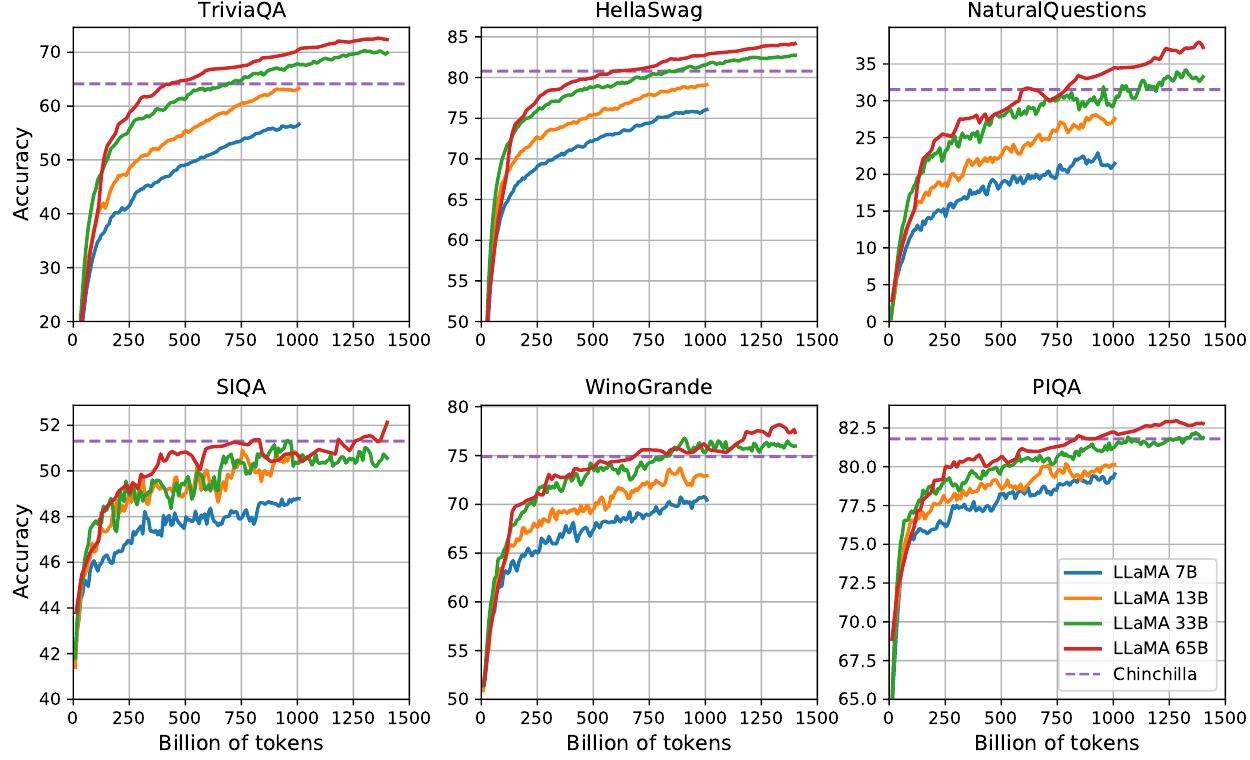

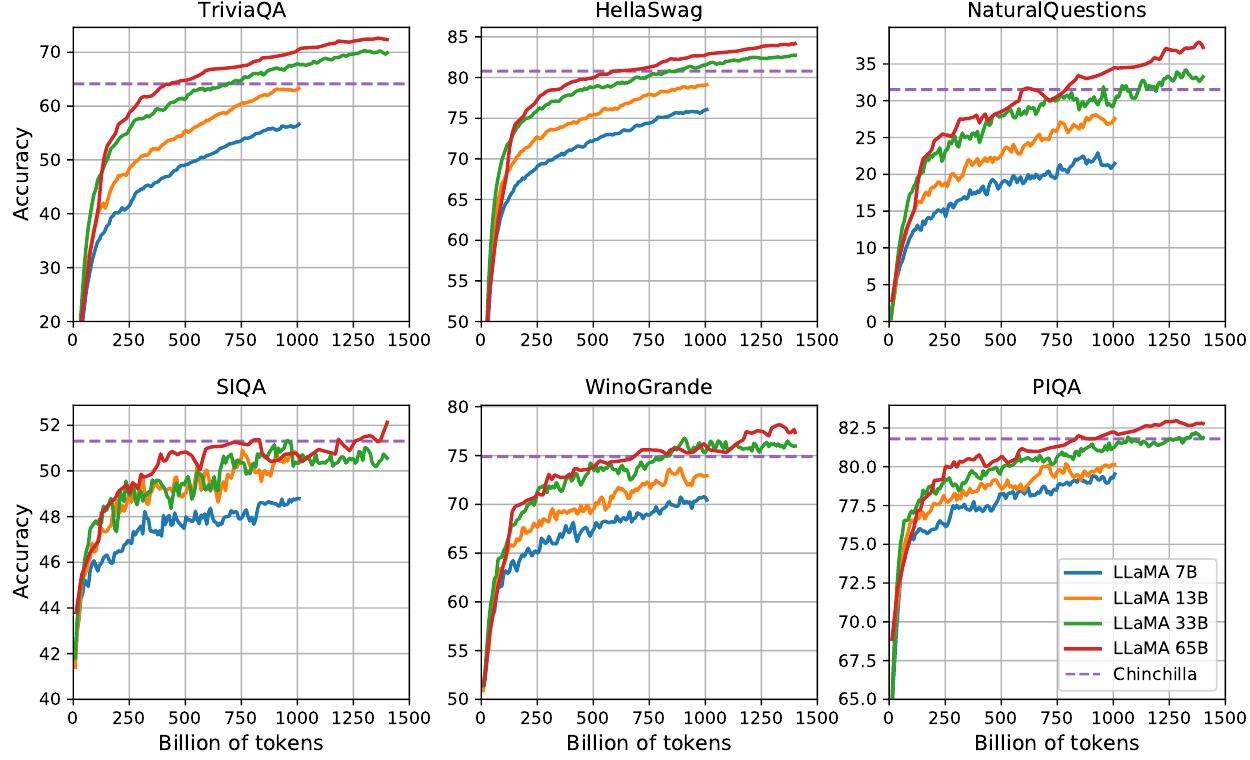

In [227]:
response, _ = answerQuestion(question="What is the LLama")

In [228]:
response

'The LLaMA is a series of language models that achieve the best possible performance at various inference budgets, by training on more tokens than what is typically used. The models range from 7B to 65B parameters with competitive performance compared to the best existing LLMs.'